## Training

### Explain how (and identify where in your code) you extracted HOG features from the training images. 

Imports

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog

%matplotlib inline

In [2]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

Colour space exploration

Histograms

In [3]:
def color_hist(img, nbins=32): # bins_range=(0, 256)
    # Compute the histogram of the RGB channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features

In [4]:
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

In [5]:
def bin_spatial(img, size=(32, 32)):    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

HOG feature extraction

In [6]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True,
                     feature_vec=True):
                         
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    
    # name returns explicitly
    hog_features = return_list[0]
    if vis == True:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return hog_features

In [43]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, 
                         orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                         spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Creat a list to append features vectors later on
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        
        # Read image by image
        #print(file)
        img = mpimg.imread(file)
        
        file_features = single_img_features(img, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                         orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
                         spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
        
        #print(len(file_features[0]))
        features.append(file_features[0])
    return features
        

In [27]:
def extract_features_old(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, 
                         orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                         spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Creat a list to append features vectors later on
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        
        # Read image by image
        img = mpimg.imread(file)
        
        # Apply color conversion if other colorspace than RGB
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(img)   
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            print(len(spatial_features))
            
        if hist_feat == True:
            channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            print(len(hist_features))
            
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True)
            file_features.append(np.ravel(hog_features))
        print(len(np.ravel(hog_features)))
        # Concatenate all the features extracted and append to features list
        
        #print(len(np.concatenate(file_features)))
        features.append(np.concatenate(file_features))
    return features
        

In [22]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32), hist_bins=32, 
                         orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                         spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    
    # Creat a list to append features vectors later on
    features = []
    
    # Iterate through the list of images
    
    # Apply color conversion if other colorspace than RGB
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)   

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        features.append(spatial_features)

    if hist_feat == True:
        channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features = color_hist(feature_image, nbins=hist_bins)
        features.append(hist_features)

    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True)
        features.append(hog_features)
        
    if vis == True:
        return np.concatenate(features), hog_image
    else:
        return np.concatenate(features)

In [9]:
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap = 'hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

In [57]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [65]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features, vis_img = single_img_features(test_img, color_space=color_space, #ToDo: Fix single_img_features so I don't have to use vis=True
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [56]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
   
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
        
    # Return the image copy with boxes drawn
    return draw_img

Function testing

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


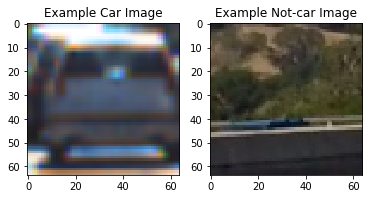

In [10]:
# images are divided up into vehicles and non-vehicles

images = glob.glob('./dataset/large/*/*/*.png')
cars = []
notcars = []

for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

left_img = car_image
right_img = notcar_image


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(left_img, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(right_img, cmap='gray')
plt.title('Example Not-car Image')

## Let's see what comes out ...

C:\Users\Martin\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


1176


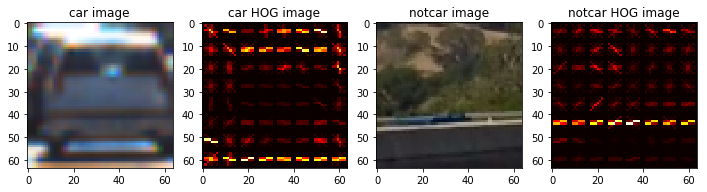

In [24]:
color_space = 'RGB'
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 #'ALL'
spatial_size = (16,16)
hist_bins = 16
spatial_feat = False # 768 features
hist_feat = False # 48 features
hog_feat = True # 1176 features

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size, 
                        hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size, 
                        hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

print(len(car_features))

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar image', 'notcar HOG image']
fig = plt.figure(figsize=(12,3))
visualize (fig, 1, 4, images, titles)

## Color classify

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

color_space = 'LUV' # RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # 'ALL' #ToDo: ALL doesn't work for some reason
spatial_size = (16,16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

t = time.time()

n_samples = 1000

random_ids = np.random.randint(0,len(cars), n_samples)

cars_test = cars #np.array(cars)[random_ids]
notcars_test = notcars #np.array(notcars)[random_ids]

#print(cars_test)
#print(notcars_test)

#img = mpimg.imread(cars_test[0])

car_features = extract_features(cars_test, color_space=color_space, spatial_size=spatial_size, 
                        hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars_test, color_space=color_space, spatial_size=spatial_size, 
                        hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

print(len(car_features))


print(time.time() - t, ' seconds to compute features')

# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

print('Feature vector length: ', len(X[0]))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to both X_train and X_test
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

print('Using: ', orient, ' orientations, ', pix_per_cell, ' picels per cell, ', cell_per_block, ' cells per block, ',
     hist_bins, ' histogram bins and ', spatial_size, ' spatial sampling')



# Use a linear SVC (support vector classifier)
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()

# Train the SVC
svc.fit(scaled_X_train, y_train)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

print('Test Accuracy of SVC = ', svc.score(scaled_X_test, y_test))
"""
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
"""

C:\Users\Martin\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


8792
284.93309807777405  seconds to compute features
Feature vector length:  2580
Using:  9  orientations,  8  picels per cell,  2  cells per block,  16  histogram bins and  (16, 16)  spatial sampling
7.38 Seconds to train SVC...
Test Accuracy of SVC =  0.982545045045


"\n# Check the prediction time for a single sample\nt=time.time()\nn_predict = 10\nprint('My SVC predicts: ', svc.predict(X_test[0:n_predict]))\nprint('For these',n_predict, 'labels: ', y_test[0:n_predict])\nt2 = time.time()\nprint(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')\n"

## Looking for cars in images

C:\Users\Martin\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


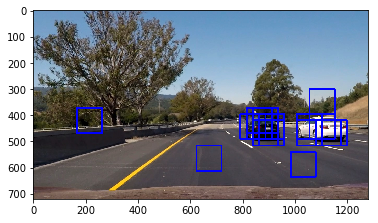

In [73]:
y_start_stop = [300, 719] # Min and max in y to search in slide_window()

image = mpimg.imread('./test_images/test6.jpg')
draw_image = np.copy(image)

image = image.astype(np.float32)/255 # The test image is jpg and we used png to train and it read the 
                                        # png from 0 to 1, but jpg is 0 to 255
    
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)  

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

# Individual functions tests

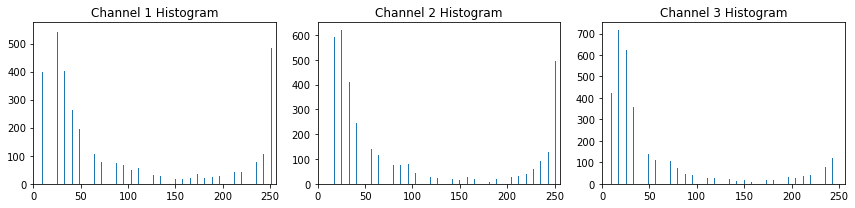

In [53]:
img = cv2.imread("./dataset/large/vehicles/KITTI_extracted/23.png")

rh, gh, bh, bincen, feature_vec = color_hist(img, nbins=32)

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('Channel 1 Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('Channel 2 Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('Channel 3 Histogram')
    fig.tight_layout()

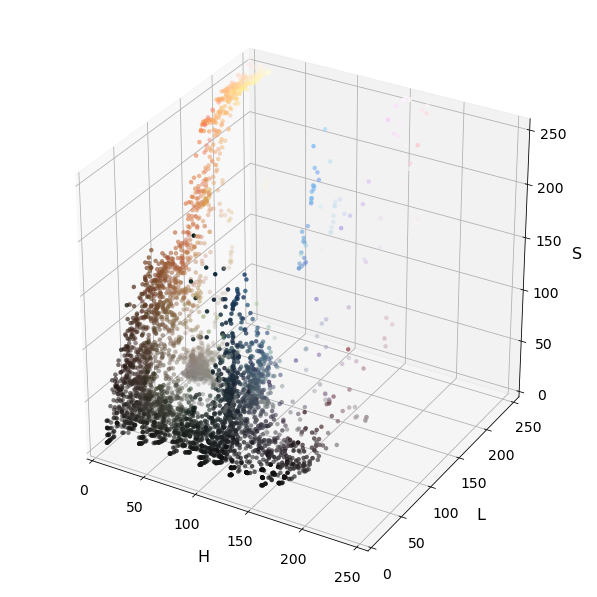

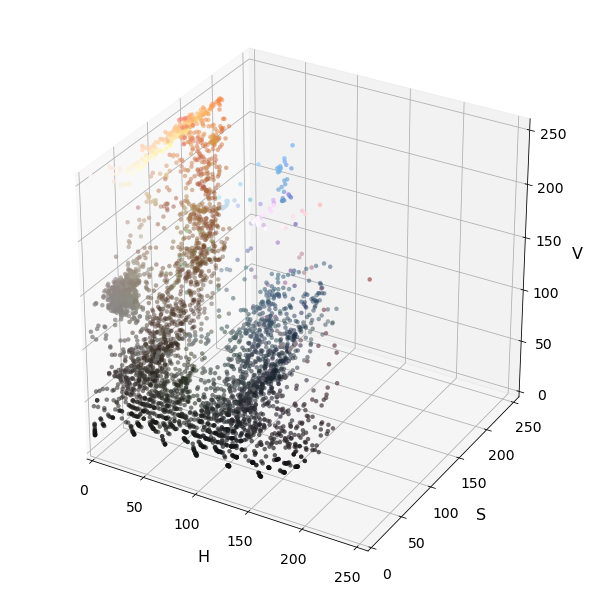

In [9]:
# Read a color image
img = cv2.imread("./dataset/large/vehicles/KITTI_extracted/7.png")
#img = cv2.imread("./dataset/large/non-vehicles/Extras/extra27.png")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

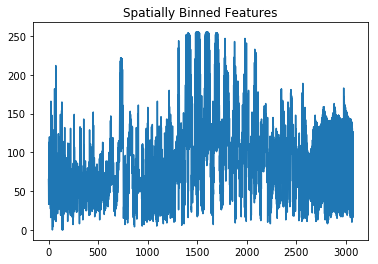

In [31]:
img = cv2.imread("./dataset/large/vehicles/KITTI_extracted/7.png")

feature_vec = bin_spatial(img, color_space='HSV', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

In [10]:
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)

left_img = car_image
right_img = hog_image


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(left_img, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(right_img, cmap='gray')
plt.title('Example Not-car Image')

NameError: name 'gray' is not defined

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)
clf.fit(iris.data, iris.target)
clf.best_params_

Draw boxes function

Functions testing

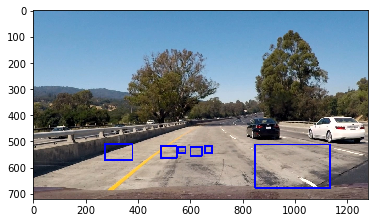

In [7]:
image = mpimg.imread('./test_images/test1.jpg')

# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

# Add bounding boxes in this format, these are just example coordinates.
bboxes = [((275, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
          ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]

result = draw_boxes(image, bboxes)
plt.imshow(result)